# Clustering Beer Styles

Using BJCP 2021 Guidelines with additional OpenAI embeddings computed per sections (overall impression, aroma, ...) and vectorized vital statistics.

In [1]:
import sqlite3
import struct
import numpy as np
import pandas as pd

# filter only style with vital metrics avoiding catch all styles
db_url = "file:data/bjcp-2021.db?mode=ro"
sql = "SELECT b.id AS id, embedding, b.name AS name, (b.abv_min + b.abv_max)/2 AS abv, (b.ibu_min + b.ibu_max)/2 AS ibu, (b.srm_min + b.srm_max)/2 AS srm, b.aroma AS content FROM embeddings_all INNER JOIN bjcp b ON b.id=embeddings_all.id WHERE b.abv_min IS NOT NULL"

def decode(blob):
    return struct.unpack("f" * 1536, blob)

conn = sqlite3.connect(db_url, uri=True)
df = pd.read_sql(sql, con=conn)
df["embedding"] = df.embedding.apply(decode).apply(np.array)  # convert string to numpy array
df.embedding.values
matrix = np.vstack(df.embedding.values)
matrix.shape

(106, 1536)

### Kmeans

Text(0.5, 1.0, 'Clusters identified visualized in language 2d using t-SNE')

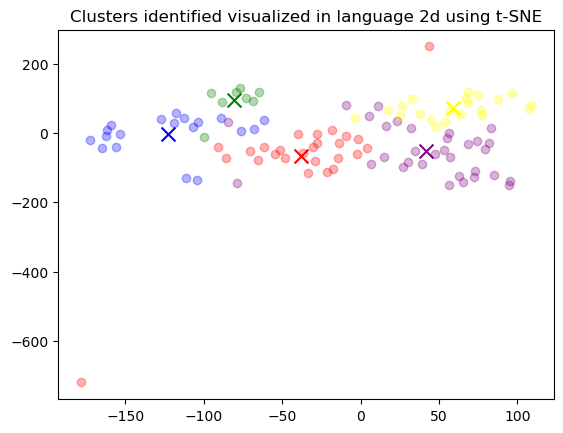

In [13]:
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

n_clusters = 5

kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42, n_init=10)
kmeans.fit(matrix)
labels = kmeans.labels_
df["Cluster"] = labels

# print(df.groupby("Cluster").abv.min().sort_values())
# print(df.groupby("Cluster").abv.max().sort_values())
# print(df.groupby("Cluster").ibu.min().sort_values())
# print(df.groupby("Cluster").ibu.max().sort_values())
# print(df.groupby("Cluster").srm.min().sort_values())
# print(df.groupby("Cluster").srm.max().sort_values())
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200)
vis_dims2 = tsne.fit_transform(matrix)

x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

for category, color in enumerate(["purple", "green", "red", "blue", "yellow", "magenta", "orange"]):
    xs = np.array(x)[df.Cluster == category]
    ys = np.array(y)[df.Cluster == category]
    plt.scatter(xs, ys, color=color, alpha=0.3)
    if len(xs) > 0:
        avg_x = xs.mean()
        avg_y = ys.mean()
        plt.scatter(avg_x, avg_y, marker="x", color=color, s=100)
plt.title("Clusters identified visualized in language 2d using t-SNE")


In [65]:
rev_per_cluster = 5

for i in range(n_clusters):
    print(f"Cluster {i} Theme:", end=" \n")
    sample_cluster_rows = df[df.Cluster == i].sample(rev_per_cluster, random_state=42)
    for j in range(rev_per_cluster):
        print(sample_cluster_rows.id.values[j], end=", ")
        print(sample_cluster_rows.name.values[j], end="\n")
        print(sample_cluster_rows.content.values[j], end="\n\n")
    print("\n")
    print("-" * 100)

Cluster 0 Theme: 
27B, Historical Beer: Kentucky Common
A clean, dry, refreshing, slightly malty dark beer with high carbonation. Mild-tasting, with light toast and caramel flavors, served very fresh as a sessionable saloon beer.

16A, Sweet Stout
A very dark, sweet, full-bodied, slightly roasty stout that can suggest coffee-and-cream, or sweetened espresso.

20A, American Porter
A malty, bitter, and often somewhat hoppy dark beer with a balanced, roasted, and frequently chocolatey character.

16C, Tropical Stout
A very dark, sweet, fruity, moderately strong stout with smooth, roasty flavors, yet no burnt harshness.

13C, English Porter
A moderate-strength dark brown English ale with a restrained roasty, bitter character. May have a range of roasted flavors, generally without burnt qualities, and often has a malty chocolate and caramel profile.



----------------------------------------------------------------------------------------------------
Cluster 1 Theme: 
10A, Weissbier
A pale

In [12]:
import openai

rev_per_cluster = 5
for i in range(n_clusters):
    print(f"Cluster {i} Theme:", end=" ")

    reviews = "\n".join(
        df[df.Cluster == i]
        .content
        .sample(rev_per_cluster, random_state=42)
        .values
    )   
          
    response = openai.Completion.create(
        engine="text-davinci-003",
        prompt=f'What do the following beer descriptions have in common?\n\nBeer overall impressions:\n"""\n{reviews}\n"""\n\nTheme:',
        temperature=0,
        max_tokens=64,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
    )
    print(response["choices"][0]["text"].replace("\n", ""))

    sample_cluster_rows = df[df.Cluster == i].sample(rev_per_cluster, random_state=42)
    for j in range(rev_per_cluster):
        print(sample_cluster_rows.id.values[j], end=", ")
        print(sample_cluster_rows.name.values[j], end=":   ")
        print(sample_cluster_rows.content.str[:70].values[j])
    print("-" * 100)


Cluster 0 Theme:  All of the beer descriptions have a malt-forward balance, with varying levels of hop aroma, roasted grain aroma, sweetness, and fruity esters.
27B, Historical Beer: Kentucky Common:   Low to medium grainy, corn-like, or sweet maltiness with a low toast, 
16A, Sweet Stout:   Mild roasted grain aroma, sometimes with coffee or chocolate notes. An
20A, American Porter:   Medium-light to medium-strong roast aroma, often with a chocolate, lig
16C, Tropical Stout:   Moderate to high intensity sweetness is prominent. Moderate to high co
13C, English Porter:   Moderate to moderately low bready, biscuity, and toasty malt aroma wit
----------------------------------------------------------------------------------------------------
Cluster 1 Theme:  All of the beer descriptions have moderate to strong esters and phenols, typically banana and clove, often well balanced with the malt. They also have light to moderate bready, doughy, or grainy wheat aroma.
10A, Weissbier:   Moderate